# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Chester et al. (2010) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model setup
L = 0.01  # length of the plate
N = 30 # mesh density

mesh = UnitSquareMesh(N,N)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

# Get the type of elements
element_type = mesh.ufl_cell().cellname()

print("Element type:", element_type)

# Get the number of elements
num_elements = mesh.num_cells()

print("Number of elements:", num_elements)

Element type: triangle
Number of elements: 1800


In [3]:
φ_o = 1.0       # initial polymer volume fraction
φ_swell = 0.001   # volumen fraction when the gel is swollen

In [4]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_phi = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
# W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))
V, Q = FunctionSpace(mesh, element_u), FunctionSpace(mesh, element_phi)

# Get the DOF count
dof_count = V.dim() + Q.dim()
print("Number of degrees of freedom:", dof_count)

Number of degrees of freedom: 8403


In [6]:
# defining the top boundary of the plate
def top(x, on_boundary):
    return near(x[1], L) and on_boundary
# defining the bottom boundary of the plate 
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
# defining the left boundary of the plate
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
# defining the right boundary of the plate
def right(x, on_boundary):
    return near(x[0], L) and on_boundary

In [7]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(1), Constant(0.0), bottom) 
u_bc_right = DirichletBC(V.sub(0), Constant(0.0), right)
u_bc_left = DirichletBC(V.sub(0), Constant(0.0), left)

# polymer volume fraction on the outer boundaries
phi_bc_top = DirichletBC(Q, Constant(0.2), top)
# phi_bc_left = DirichletBC(Q, Constant(φ_swell), left)
phi_bc_right = DirichletBC(Q, Constant(φ_swell), right)

# bcs = [u_bc_bottom, u_bc_right, mu_bc_bottom, mu_bc_right]
# bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]

# bc_u = [u_bc_bottom, u_bc_left] #u_bc_right]
# bc_phi = [phi_bc_top, phi_bc_right] #phi_bc_left]

bc_u = [u_bc_bottom, u_bc_left, u_bc_right]
bc_phi = [phi_bc_top]#, phi_bc_right] #phi_bc_left]

In [8]:
(du, dφ) = TrialFunction(V), TrialFunction(Q)
(v, q) = TestFunction(V), TestFunction(Q)

(u, φ) = Function(V), Function(Q)
(uold, φold) = Function(V), Function(Q)
(un, φn) = Function(V), Function(Q)

# Create intial conditions and interpolate
# u_init = InitialConditions()
φ_init = Expression("0.75", degree=1)
φold.interpolate(φ_init)
φ.assign(φold)

Kinematic quantities

In [9]:
# Model parameters
# Elasticity parameters
G0, χ = Constant(1.0e6), Constant(0.2)#Constant(0.1)
K = Constant(100.0e6)#Constant(3.93e6) # Bulk modulus
ΩK = Constant(100.0e6)
NΩ = Constant(1e-3)
Ω = Constant(1.7e-28)#Constant(1e-4)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
RT = Constant(8.31446261815324*298)
D = Constant(5e-8)#Constant(0.1)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)
gamma_s = Constant(10.)

µ_o = Constant(0.0)

alpha_r = 1.0 # Robin Boundary constant

print(2.5e-5/(1.3806488e-23*298))

6076318427225260.0


In [10]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [11]:
# Cauchy stress
def T_(u,φ):
    return variable(inv(J(u))*(G0*(B(u) - (φ**(-2))*I)))# + (1/φ)*K*ln(J(u)*φ)*I))

# Piola stress - P = JTF^-T
def PK1(u,φ):
    return variable(G0*(B(u) - (φ**(-2))*I)*inv(F(u).T)) # <= as in Chester et al. 2010
# Chemical potential - µ
def µ_(u,φ):
    return variable(µ_o + kBT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) + (Ω*G0)*(0.999/φ - 0.999*φ)) # <= as in Chester et al. 2010

In [12]:
dt = Constant(0.)

# Tentative displacement step
# Forces balance
Pi_mech_n = inner(PK1(u,φ), grad(v))*dx

Jac_n = derivative(Pi_mech_n, u, du) 

# Mass balance

D = 2.5e-5 # <= this works for Chester et al. 2010
phi_form = ((φ - φold)/dt*q
            - (D/(kBT))*(dot(grad(φ),grad(µ_(u,φ))))*q 
            - (D/(kBT))*(dot(((φ**2)*((1 - 0.999*φ)/φ))*grad(µ_(u,φ)),grad(q))))*dx

Jac_phi = derivative(phi_form, φ, dφ)

In [13]:
# Time-stepping
Nincr = 10
t = np.linspace(0, 10, Nincr+1)
# t = np.logspace(0, 4, Nincr+1)
Nx = 10
x = np.linspace(0, L, Nx)
µ_res = np.zeros((Nx, Nincr+1))
φ_res = np.zeros((Nx, Nincr+1))
sigma_y_array = np.zeros((Nx, Nincr+1))
phi_res = np.zeros((Nx, Nincr+1))
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    print("t =", t_current) 
    dt.assign(dti)

    # Tolerance and initial error
    tol = 1e-10
    E_u = 1000
    E_phi = 1000

    # Iteration counter
    iterations = 0
    max_iterations = 10 # Maximum number of iterations to prevent infinite loops     

    while E_u > tol or E_phi > tol and iterations < max_iterations:
        iterations += 1

        # Compute tentative displacement
        begin("Computing tentative displacement")
        solve(Pi_mech_n == 0, u, bc_u, J=Jac_n, solver_parameters={"newton_solver":
                                            {"relative_tolerance": 1e-10, "convergence_criterion": "incremental"}})

        # Compute phi
        begin("Computing phi")
        solve(phi_form == 0, φ, bc_phi, J=Jac_phi)
        φ_res[:, i+1] = [φ(L/2,xi) for xi in x]

        # Compute errors
        E_u = errornorm(u, un, norm_type='L2')     
        E_phi = errornorm(φ, φn, norm_type='L2')

        # Save old solutions
        un.assign(u)
        φn.assign(φ)

        print(f'Iteration {iterations}, error_u: {E_u}, error_phi: {E_phi}')

    # Check if solution converged
    if E_u <= tol and E_phi <= tol:
        print('Solution converged')
    else:
        print('Solution did not converge')

    uold.assign(u)
    φold.assign(φ)

    mu_y = µ_(u,φ)
    mu_y_P1 = project(mu_y/kBT, Q)
    µ_res[:, i+1] = [mu_y_P1(L/2, xi) for xi in x]

    sigma_y = inv(J(u))*G0*(1 - φ**(-2))
    sigma_y_P1 = project(sigma_y, Q)
    sigma_y_array[:, i+1] = [sigma_y_P1(L/2, xi) for xi in x]  
   
    plt.figure()
    p = plot(φ, title="Polymer volume fraction")
    plt.colorbar(p)
    plt.close()
     
    
    plt.figure(figsize=(6.4,5))
    p = plot(u, mode="displacement")
    # plt.xlim((-0.05, 1.7))
    # plt.ylim((-0.05, 1.7))
    # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
    plot(mesh, linewidth=1.0)
    cbar = plt.colorbar(p, format="%.2f")#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coordinate", fontsize=16)
    plt.ylabel("$Y$-coordinate", fontsize=16)
    # plt.legend(["deformed gel"])
    plt.title("deformed gel ($t = {:.1f}$)".format(t_current), fontsize = 18)
    # plt.savefig('results/Chester/Fig_2DFEM_def_gel_{:.1f}.pdf'.format(t_current))
    plt.close() 

    plt.figure(figsize=(6,5))
    p = plot(PK1(u,φ)[0,0], title="$sigma_{xx}$ nominal stress")
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coordinate", fontsize=16)
    plt.ylabel("$Y$-coordinate", fontsize=16)
    plt.title("stress $PK1_{xx}$", fontsize = 18)
    # plt.savefig('results/Chester/Fig_2DFEM_stress_{:.1f}.pdf'.format(t_current))
    plt.close()
    
    print("t =", dti)


Increment 1
t = 1.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Computing tentative displacement
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 9.902e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-10)
    Newton iteration 1: r (abs) = 1.847e-02 (tol = 1.000e-10) r (rel) = 1.865e-01 (tol = 1.000e-10)
    Newton iteration 2: r (abs) = 3.925e-04 (tol = 1.000e-10) r (rel) = 3.963e-03 (tol = 1.000e-10)
    Newton iteration 3: r (abs) = 1.636e-07 (tol = 1.000e-10) r (rel) = 1.652e-06 (tol = 1.000e-10)
    Newton iteration 4: r (abs) = 2.838e-14 (tol = 1.000e-10) r (rel) = 2.866e-13 (tol = 1.000e-10)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Computing phi
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
    Solving nonlinear variational problem.
Calling 

In [14]:
# For polymer volume fraction
Ph4_mesh = 0.3325209691907925  #200
Ph2_mesh = 0.33252255189283436 #100
Ph_mesh = 0.3325288635321186  #N = 50 , Nincr = 10
Ph0_mesh = 0.33255656011111795 # 25 

print("Convergence computed for phi at one point in the domain")
conv_alpha_mesh = 1/np.log10(2)*np.log10( np.abs( (Ph_mesh - Ph2_mesh)/(Ph2_mesh - Ph4_mesh)))
print(conv_alpha_mesh)

error0 = np.abs(Ph4_mesh - Ph0_mesh)
print(error0)

error1 = np.abs(Ph4_mesh - Ph_mesh)
print(error1)

error2 = np.abs(Ph4_mesh - Ph2_mesh)
print(error2)

print("Convergence computed for phi error at one point in the domain")
conv_alpha_mesh_error = 1/np.log10(2)*np.log10( np.abs( (error0 - error1)/(error1 - error2)))
print(conv_alpha_mesh_error)

Ph4_time = 0.30859447390609657  #100 , N = 50
Ph2_time = 0.3116259272870799 #50
Ph_time = 0.3172617603896303  #25
Ph0_time = 0.3268735828087059 # 13

print("Time convergence computed for phi at one point in the domain")
conv_alpha_time = 1/np.log10(2)*np.log10( np.abs( (Ph_time - Ph2_time)/(Ph2_time - Ph4_time)))
print(conv_alpha_time)

error0_time = np.abs(Ph4_time - Ph0_time)
print(error0_time)

error1_time = np.abs(Ph4_time - Ph_time)
print(error1_time)

error2_time = np.abs(Ph4_time - Ph2_time)
print(error2_time)

print("Time convergence computed for phi error at one point in the domain")
conv_alpha_time_error = 1/np.log10(2)*np.log10( np.abs( (error0_time - error1_time)/(error1_time - error2_time)))
print(conv_alpha_time_error)

print(φ_res[0, -1])

# For displacement
Ph4_mesh_u = 2.5788990675154295  #200
Ph2_mesh_u = 2.578856725598165 #100
Ph_mesh_u = 2.578687571049971  #N = 50 , Nincr = 10
Ph0_mesh_u = 2.5779254462594845 # 25 

print("Convergence computed for u at one point in the domain")
conv_alpha_mesh_u = 1/np.log10(2)*np.log10( np.abs( (Ph_mesh_u - Ph2_mesh_u)/(Ph2_mesh_u - Ph4_mesh_u)))
print(conv_alpha_mesh_u)

error0_u = np.abs(Ph4_mesh_u - Ph0_mesh_u)
print(error0_u)

error1_u = np.abs(Ph4_mesh_u - Ph_mesh_u)
print(error1_u)

error2_u = np.abs(Ph4_mesh_u - Ph2_mesh_u)
print(error2_u)

print("Convergence computed for u error at one point in the domain")
conv_alpha_mesh_error_u = 1/np.log10(2)*np.log10( np.abs( (error0_u - error1_u)/(error1_u - error2_u)))
print(conv_alpha_mesh_error_u)

u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude,Q)
print(u_magnitude(L,L))

Convergence computed for phi at one point in the domain
1.9956250759017116
3.559092032545674e-05
7.894341326086796e-06
1.5827020418690552e-06
Convergence computed for phi error at one point in the domain
2.13362112827752
Time convergence computed for phi at one point in the domain
0.8946192526360842
0.01827910890260931
0.00866728648353371
0.0030314533809833177
Time convergence computed for phi error at one point in the domain
0.770181105697287
0.3325492110748641
Convergence computed for u at one point in the domain
1.9981834666242193
0.000973621255945023
0.00021149646545870482
4.234191726437686e-05
Convergence computed for u error at one point in the domain
2.171685275719554
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.027007677669099738


In [15]:
# def solver_1D_ref_sol(N = 200):

# 1D NL PDE for phi (polymer volume fraction)
N = 200
mesh_phi_1D = UnitIntervalMesh(N)

# Scale the mesh to the desired domain size
coordinates = mesh_phi_1D.coordinates()
for coord in coordinates:
    coord *= L


element_phi_1D = FiniteElement('CG', mesh_phi_1D.ufl_cell(), 2)
P = FunctionSpace(mesh_phi_1D, element_phi_1D)

dphi = TrialFunction(P)
p = TestFunction(P)

phi = Function(P)
phi_old = Function(P)

# Create initial condition
phi_init = Expression("0.75", degree=1)
phi_old.interpolate(phi_init)
phi.assign(phi_old)

# BCs
phi_right_1D = 0.2
# phi_bc_left = DirichletBC(P, Constant(0.999), left)
phi_bc_right_1D = DirichletBC(P, Constant(phi_right_1D), right)

bc_phi_1D = phi_bc_right_1D

dt = Constant(0.)

def mu1D_(phi):
    return variable(µ_o + kBT*(ln(1 - 0.999*phi) + phi + χ*(phi**2)) + (Ω*G0)*(0.999/phi - 0.999*phi))

D1D = 2.5e-5
phi_form_1D = ((phi - phi_old)/dt*p
            - (D1D/(kBT))*(dot(grad(phi),grad(mu1D_(phi))))*p 
            - (D1D/(kBT))*(dot(((phi**2)*((1 - 0.999*phi)/phi))*grad(mu1D_(phi)),grad(p))))*dx
            
Jac_phi_1D = derivative(phi_form_1D, phi, dphi)

Nincr = 10
t = np.linspace(0, 10, Nincr+1)
# t = np.logspace(-2, 0, Nincr+1)
Nx = 10
x = np.linspace(0, L, Nx)

phi_res = np.zeros((Nx, Nincr+1))

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)

    begin("Computing 1D lambda sol")
    solve(phi_form_1D == 0, phi, bc_phi_1D, J=Jac_phi_1D)#, 
        # solver_parameters={'linear_solver': 'gmres',
        #                  'preconditioner': 'ilu'})
    phi_old.assign(phi)
    phi_res[:, i+1] = [phi(xi) for xi in x]
    end()

Calling FFC just-in-time (JIT) compiler, this may take some time.


Increment 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
                                                                                                                        Computing 1D lambda sol
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Increment 2                                                                                                                          Solving nonlinear variational problem.

Increment 3
Increment 4
Increment 5
Increment 6
Increment 7
Increment 8
Increment 9
Increment 10
                                                                                                                            Newton iteration 0: r (abs) = 6.737e-01 (tol = 1.000e-

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line8), but could not find a label for it.
  warnings.warn(


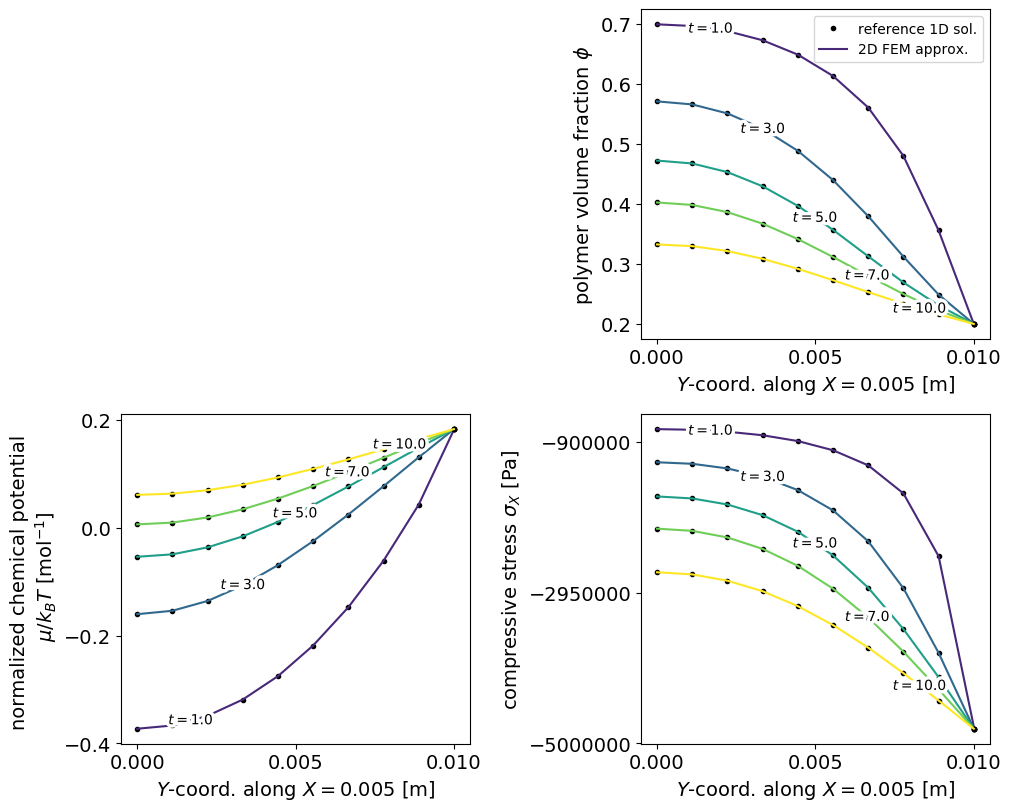

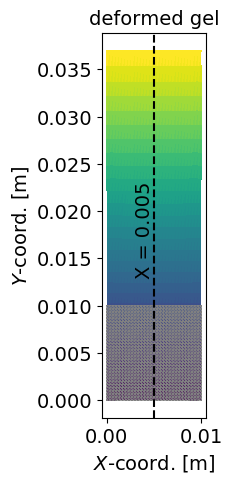

In [16]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))
axes = axes.flatten()

ax = axes[0]
ax.set_visible(False)

# stretch
# fig, ax = plt.subplots()
ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in [1, 3, 5, 7, 10]:
    ax.plot(x, phi_res[:, n], 'k.')
    ax.plot(x, φ_res[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))


labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("polymer volume fraction $\phi$", fontsize=14)
ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_phi = np.linspace(0.2, 0.72, 3)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)

# chemical potential
# fig, ax = plt.subplots()
ax = axes[2]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

phi_x = phi_res[:, 1::Nincr//10]
mu_x = (1.3806488e-23*298)*(np.log(1 - 0.999*phi_x) + phi_x + 0.2*(phi_x**2)) + ((1.7e-28)*(1e6))*(0.999/phi_x - 0.999*phi_x)

for n in [1, 3, 5, 7, 10]:
    ax.plot(x, mu_x[:, n-1]/(1.3806488e-23*298), 'k.')
    ax.plot(x, µ_res[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("normalized chemical potential \n $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_mu = np.linspace(0.2, -0.4, 4)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks_mu)

ax = axes[3]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

sigma_y = 1e6*phi_x*(1 - phi_x**(-2))

for n in [1, 3, 5, 7, 10]:
    ax.plot(x, sigma_y[:, n-1], 'k.')
    ax.plot(x, sigma_y_array[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("compressive stress $\sigma_X$ [Pa]", fontsize=14) 
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_stress = np.linspace(-5.0e6, -0.9e6, 3)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks_stress)

# plt.savefig('results/Chester/Fig_refsol_2DFEM_x001.pdf') 
plt.show()

# ax = axes[3]
plt.figure(figsize=(5,5))
p = plot(u, mode="displacement")
plt.axvline(x = 0.005, color = 'k', linestyle = '--', label = 'X = 0.005')
plt.text(0.004, 0.018, 'X = 0.005', rotation=90, ha='center', va='center', fontsize = 14)
plot(mesh, linewidth=0.7)
# cbar = plt.colorbar(p)#, shrink = 0.5)
# cbar.ax.tick_params(labelsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("$X$-coord. [m]", fontsize=14)
plt.ylabel("$Y$-coord. [m]", fontsize=14)
# plt.legend(frameon=False, fontsize=14, loc='best')
# plt.legend(["deformed gel"])
plt.title("deformed gel", fontsize = 14)
# plt.savefig('results/Chester/Fig_2DFEM_def_gel_x001.pdf')   
plt.show() 